In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import pandas as pd
import lasagne
from parmesan.distributions import log_normal2, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
latent_size = 100
analytic_kl_term = True
lr = 0.001
num_epochs = 50
model_filename = "svhn_conv_vae"
nplots = 15

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.tensor4()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_x = np.rollaxis(svhn_train['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

Using SVHN dataset


In [4]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, 3, 32, 32))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.Conv2DLayer(l_noise, num_filters = 32, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV1')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 64, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV2')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 128, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV3')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='ENC_DENSE2')

l_mu = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_MU')
l_log_var = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_LOG_VAR')

#sample the latent variables using mu(x) and log(sigma^2(x))
l_z = SimpleSampleLayer(mean=l_mu, log_var=l_log_var)

In [5]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='DEC_DENSE1')
l_dec_h1 = lasagne.layers.ReshapeLayer(l_dec_h1, (batch_size, -1, 4, 4))
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 128, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV1')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 64, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV2')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 32, filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV3')
l_dec_x_mu = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_MU')
l_dec_x_mu = lasagne.layers.ReshapeLayer(l_dec_x_mu, (batch_size, -1))
l_dec_x_log_var = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_LOG_VAR')
l_dec_x_log_var = lasagne.layers.ReshapeLayer(l_dec_x_log_var, (batch_size, -1))

# Get outputs from model
# with noise
z_train, z_mu_train, z_log_var_train, x_mu_train, x_log_var_train = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu, l_dec_x_log_var], sym_x, deterministic=False
)

# without noise
z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, x_log_var_eval = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu, l_dec_x_log_var], sym_x, deterministic=True
)

In [6]:
#Calculate the loglikelihood(x) = E_q[ log p(x|z) + log p(z) - log q(z|x)]
def ELBO(z, z_mu, z_log_var, x_mu, x_log_var, x):
    """
    Latent z       : gaussian with standard normal prior
    decoder output : bernoulli

    When the output is bernoulli then the output from the decoder
    should be sigmoid. The sizes of the inputs are
    z: (batch_size, num_latent)
    z_mu: (batch_size, num_latent)
    z_log_var: (batch_size, num_latent)
    x_mu: (batch_size, num_features)
    x: (batch_size, num_features)
    """
    kl_term = kl_normal2_stdnormal(z_mu, z_log_var).sum(axis=1)
    log_px_given_z = log_normal2(x.reshape((batch_size, -1)), x_mu, x_log_var).sum(axis=1)
    LL = T.mean(-kl_term + log_px_given_z)

    return LL

# TRAINING LogLikelihood
LL_train = ELBO(z_train, z_mu_train, z_log_var_train, x_mu_train, x_log_var_train, sym_x)

# EVAL LogLikelihood
LL_eval = ELBO(z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, x_log_var_eval, sym_x)


params = lasagne.layers.get_all_params([l_dec_x_mu, l_dec_x_log_var], trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(-LL_train, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_CONV1.W (32, 3, 4, 4)
ENC_CONV1.b (32,)
ENC_CONV2.W (64, 32, 4, 4)
ENC_CONV2.b (64,)
ENC_CONV3.W (128, 64, 4, 4)
ENC_CONV3.b (128,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
ENC_Z_MU.W (512, 100)
ENC_Z_MU.b (100,)
ENC_Z_LOG_VAR.W (512, 100)
ENC_Z_LOG_VAR.b (100,)
DEC_DENSE1.W (100, 512)
DEC_DENSE1.b (512,)
DEC_CONV1.W (32, 128, 5, 5)
DEC_CONV1.b (128,)
DEC_CONV2.W (128, 64, 5, 5)
DEC_CONV2.b (64,)
DEC_CONV3.W (64, 32, 5, 5)
DEC_CONV3.b (32,)
DEC_MU.W (32, 3, 4, 4)
DEC_MU.b (3,)
DEC_LOG_VAR.W (32, 3, 4, 4)
DEC_LOG_VAR.b (3,)


In [7]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], LL_train, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], LL_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], x_mu_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [8]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        results = plot_results(0)
        plt.figure(figsize=(2, nplots))
        for i in range(0,nplots):
            plt.subplot(nplots,2,(i+1)*2-1)
            plt.imshow((svhn_std*test_x[i].transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
            plt.subplot(nplots,2,(i+1)*2)
            plt.imshow((svhn_std*results[i].reshape(3,32,32).transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
        plt.show()
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model([l_dec_x_mu, l_dec_x_log_var], model_filename)
else:
    read_model([l_dec_x_mu, l_dec_x_log_var], model_filename)
    

In [24]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    
def svhn_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 3, 32, 32)

def svhn_dist(imgs, img):
    assert imgs.shape == (batch_size, 3*32*32)
    img = img.reshape((3*32*32,))
    
    imgs_pixels = imgs*svhn_std + svhn_mean
    img_pixels = img*svhn_std + svhn_mean
    
    diff = np.linalg.norm(imgs_pixels - img_pixels, axis = 1)
    return np.mean(diff), np.std(diff)

In [10]:
def kld(mean1, log_var1, mean2, log_var2):
    mean_term = (T.exp(0.5*log_var1) + (mean1-mean2)**2.0)/T.exp(0.5*log_var2)
    return mean_term + log_var2 - log_var1 - 0.5

# Autoencoder outputs
mean, log_var, reconstruction = lasagne.layers.get_output(
    [l_mu, l_log_var, l_dec_x_mu], inputs = sym_x, deterministic=True)
    
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_mean =  T.vector()
adv_log_var = T.vector()
adv_confusion = kld(mean, log_var, adv_mean, adv_log_var).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_mean, adv_log_var, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_mean_log_var = theano.function([sym_x], [mean, log_var])

In [21]:
def adv_test(orig_img, target_img, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Get latent variables of the target
    adv_mean_values, adv_log_var_values = adv_mean_log_var(svhn_input(test_x[target_img]))
    adv_mean_values = adv_mean_values[0]
    adv_log_var_values = adv_log_var_values[0]

    original_reconstructions = adv_plot(svhn_input(test_x[orig_img]))
    target_reconstructions = adv_plot(svhn_input(test_x[target_img]))

    orig_recon_dist, orig_recon_dist_std = svhn_dist(original_reconstructions, test_x[orig_img])
    target_recon_dist, target_recon_dist_std = svhn_dist(target_reconstructions, test_x[target_img])
    orig_target_recon_dist, orig_target_recon_dist_std = svhn_dist(original_reconstructions, test_x[target_img])
    target_orig_recon_dist, target_orig_recon_dist_std = svhn_dist(target_reconstructions, test_x[orig_img])

    # Plot original reconstruction    
    if plot:
        plt.figure()
        show_svhn(test_x[orig_img], 1, "Original")
        show_svhn(original_reconstructions[0], 2, "Original rec.")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g = adv_function(svhn_input(test_x[orig_img]), adv_mean_values, adv_log_var_values, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_imgs = adv_plot(svhn_input(test_x[orig_img]))
    
    orig_dist, orig_dist_std = svhn_dist(adv_imgs, test_x[orig_img])
    adv_dist, adv_dist_std = svhn_dist(adv_imgs, test_x[target_img])
    recon_dist, recon_dist_std = svhn_dist(adv_imgs, test_x[orig_img]+x.reshape(3, 32, 32))

    # Plotting results
    if plot:
        show_svhn((test_x[orig_img].flatten()+x), 3, "Adversarial")
        show_svhn(test_x[target_img], 4, "Target")
        show_svhn(adv_imgs[0], 5, "Adversarial rec.")
        show_svhn(x, 6, "Distortion")
        plt.show()
        
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])
    
    returns = (np.linalg.norm(x),
               orig_dist, 
               orig_dist_std, 
               adv_dist, 
               adv_dist_std, 
               orig_recon_dist, 
               orig_recon_dist_std, 
               target_recon_dist, 
               target_recon_dist_std,
               recon_dist,
               recon_dist_std,
               orig_target_dist,
               orig_target_recon_dist,
               orig_target_recon_dist_std,
               target_orig_recon_dist,
               target_orig_recon_dist_std)
    
    return returns

In [22]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    noise_dist = []
    orig_dist=[]
    orig_dist_std=[]
    adv_dist=[]
    adv_dist_std=[]
    target_recon_dist=[]
    target_recon_dist_std=[]
    recon_dist=[]
    recon_dist_std=[]
    orig_target_dist=[]
    orig_target_recon_dist=[]
    orig_target_recon_dist_std=[]
    target_orig_recon_dist=[]
    target_orig_recon_dist_std=[]
    
    C = np.logspace(-20, 20, 100, base = 2, dtype = np.float32)
    
    for c in C:
        noise, od, ods, ad, ads, ore, ores, tre, tres, recd, recs, otd, otrd, otrds, tord, tords = adv_test(orig_img, target_img, C=c, plot = False)
        noise_dist.append(noise)
        orig_dist.append(od)
        orig_dist_std.append(ods)
        adv_dist.append(ad)
        adv_dist_std.append(ads)
        target_recon_dist.append(tre)
        target_recon_dist_std.append(tres)
        recon_dist.append(recd)
        recon_dist_std.append(recs)
        orig_target_dist.append(otd)
        orig_target_recon_dist.append(otrd)
        orig_target_recon_dist_std.append(otrds)
        target_orig_recon_dist.append(tord)
        target_orig_recon_dist_std.append(tords)

    noise_dist = np.array(noise_dist)
    orig_dist = np.array(orig_dist)
    orig_dist_std = np.array(orig_dist_std)
    adv_dist = np.array(adv_dist)
    adv_dist_std = np.array(adv_dist_std)
    target_recon_dist = np.array(target_recon_dist)
    target_recon_dist_std = np.array(target_recon_dist_std)
    recon_dist = np.array(recon_dist)
    recon_dist_std = np.array(recon_dist_std)
    orig_target_dist = np.array(orig_target_dist)
    orig_target_recon_dist = np.array(orig_target_recon_dist)
    orig_target_recon_dist_std = np.array(orig_target_recon_dist_std)
    target_orig_recon_dist = np.array(target_orig_recon_dist)
    target_orig_recon_dist_std = np.array(target_orig_recon_dist_std)
    
    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print orig_img, target_img, bestC

    ex_noise, _, _, ex_adv_dist, _, orig_reconstruction_dist, _, target_reconstruction_dist, _, _, _, ex_orig_target_dist, ex_orig_target_recon_dist, _, _, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axvline(x=ex_orig_target_dist, linewidth = 2, color='cyan', label = "Original - Target")
        plt.axhline(y=ex_orig_target_recon_dist, linewidth = 2, color = 'DarkOrange', label = "Original rec. - Target")
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'red', label = "Target rec. - Target")
        plt.scatter(noise_dist, adv_dist)
        plt.scatter([ex_noise], [ex_adv_dist], color = "red")
        plt.ylabel("Adversarial rec. - Target")
        plt.xlabel("Distortion")
        plt.legend()
        plt.plot()
        
    df = pd.DataFrame({'orig_img': orig_img,
                       'target_img': target_img,
                       'bestC': bestC,
                       'orig_reconstruction_dist': orig_reconstruction_dist,
                       'target_reconstruction_dist': target_reconstruction_dist,
                       'noise_dist': noise_dist,
                       'orig_dist': orig_dist,
                       'orig_dist_std': orig_dist_std,
                       'adv_dist': adv_dist,
                       'adv_dist_std': adv_dist_std,
                       'target_recon_dist': target_recon_dist,
                       'target_recon_dist_std': target_recon_dist_std,
                       'recon_dist': recon_dist,
                       'recon_dist_std': recon_dist_std,
                       'orig_target_dist': orig_target_dist,
                       'orig_target_recon_dist': orig_target_recon_dist,
                       'orig_target_recon_dist_std': orig_target_recon_dist_std,
                       'target_orig_recon_dist': target_orig_recon_dist,
                       'target_orig_recon_dist_std': target_orig_recon_dist_std,
                       'C': C})
    
    return df

1804 13838 721.547


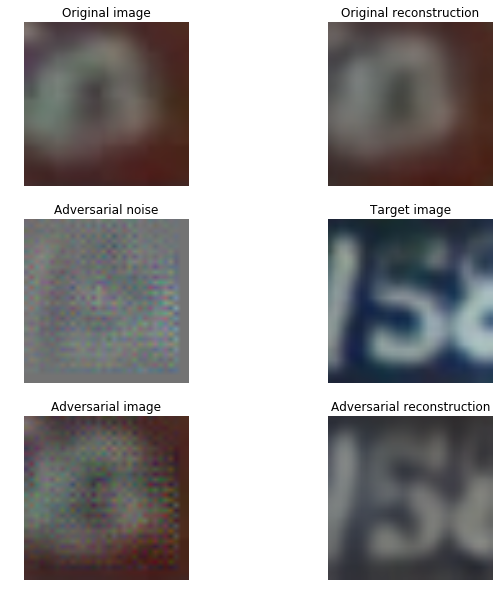

Iter 0 Time 255.397480965 sec
17043 24423 721.547


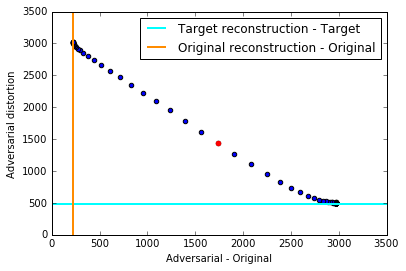

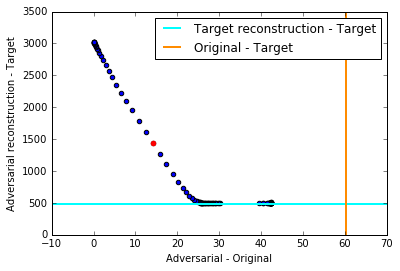

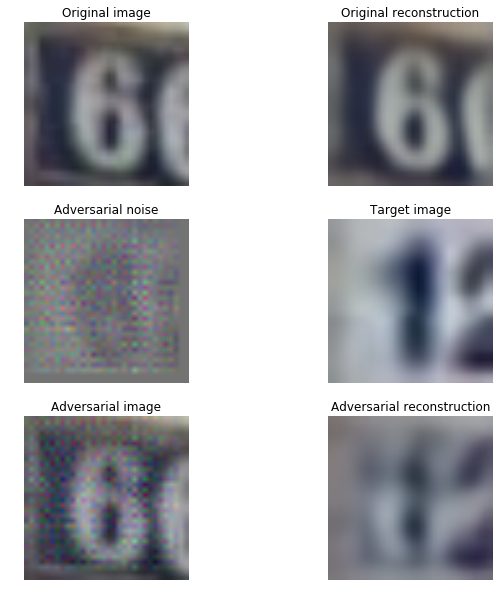

Iter 1 Time 416.975816965 sec
24108 6219 311.444


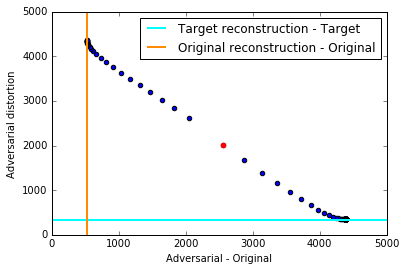

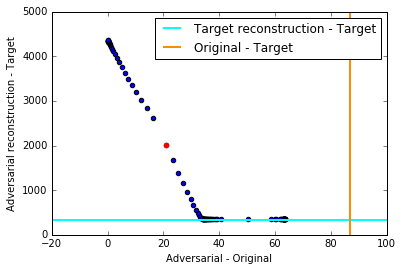

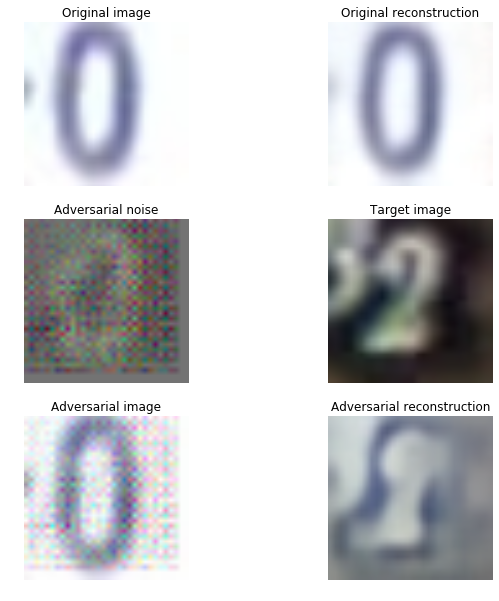

Iter 2 Time 444.23576498 sec
14648 7867 954.757


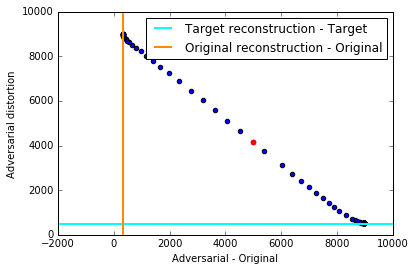

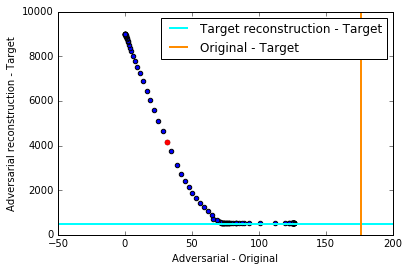

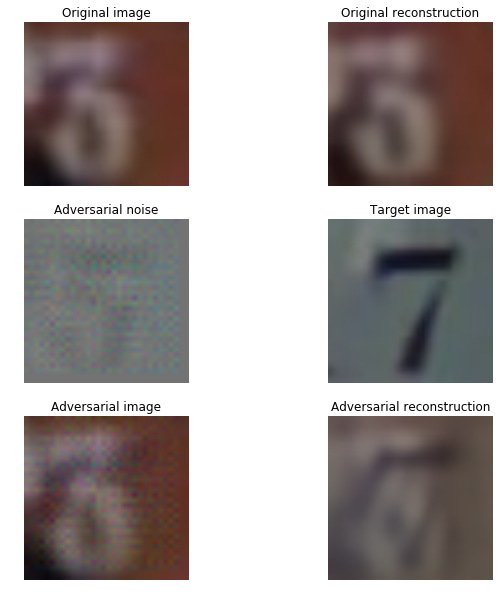

Iter 3 Time 237.087356091 sec
13546 14419 721.547


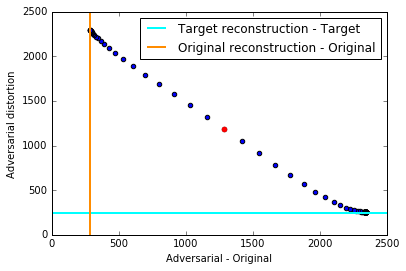

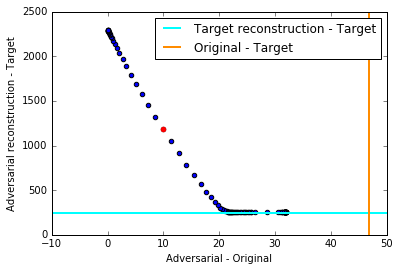

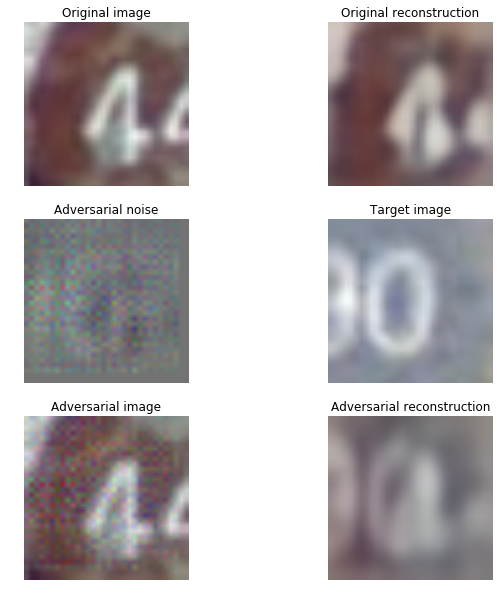

Iter 4 Time 345.42644906 sec
917 18673 954.757


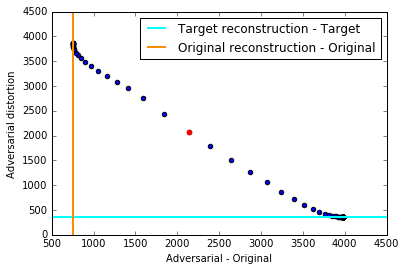

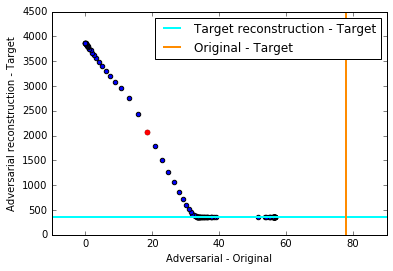

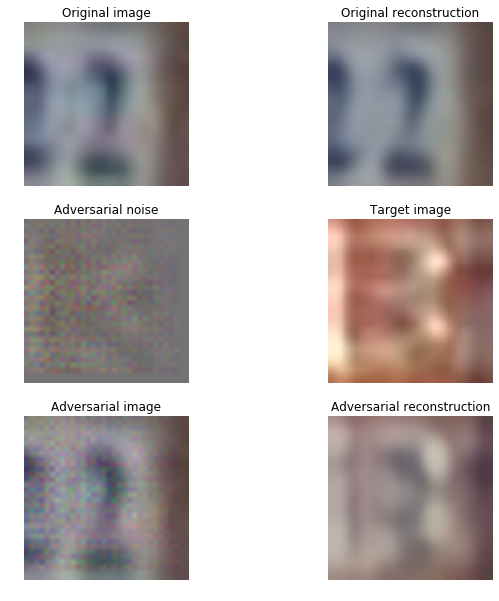

Iter 5 Time 238.858319998 sec
16447 16411 721.547


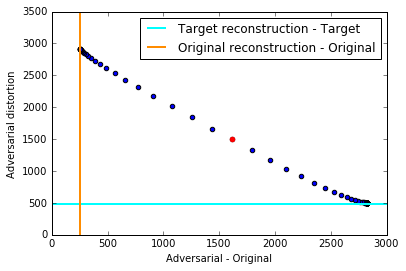

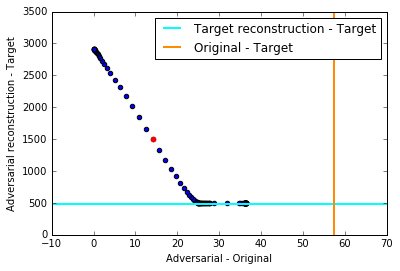

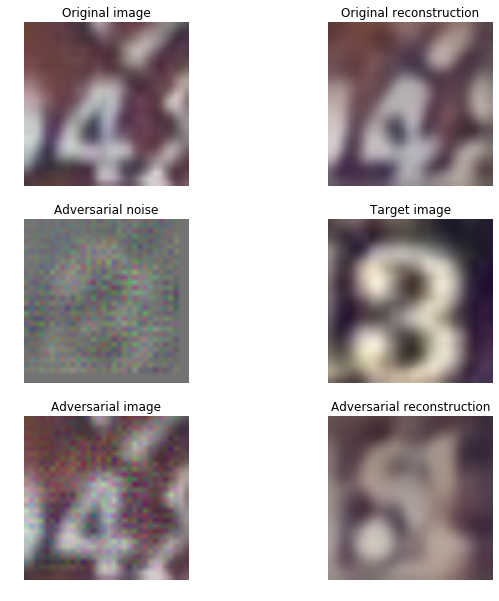

Iter 6 Time 287.614323139 sec
14071 13784 311.444


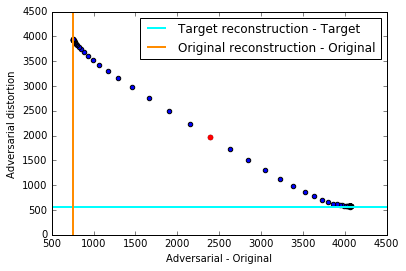

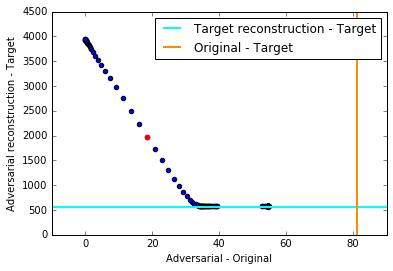

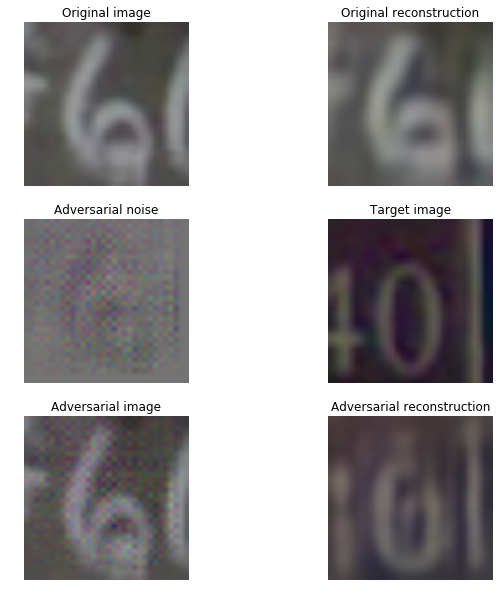

Iter 7 Time 196.177399158 sec
12406 25401 954.757


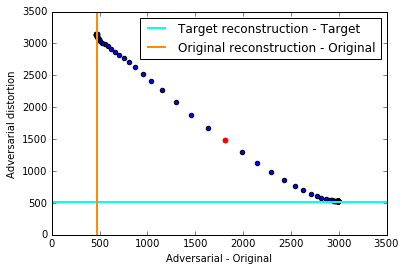

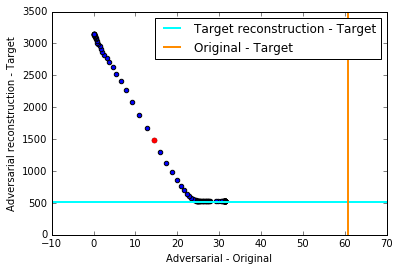

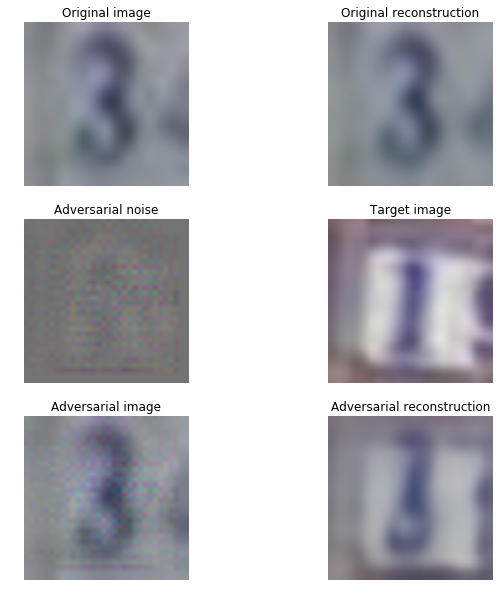

Iter 8 Time 170.475847006 sec
25766 17283 1263.34


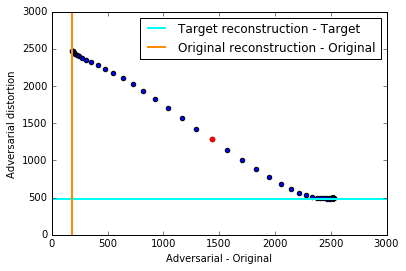

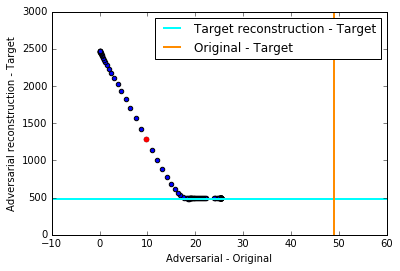

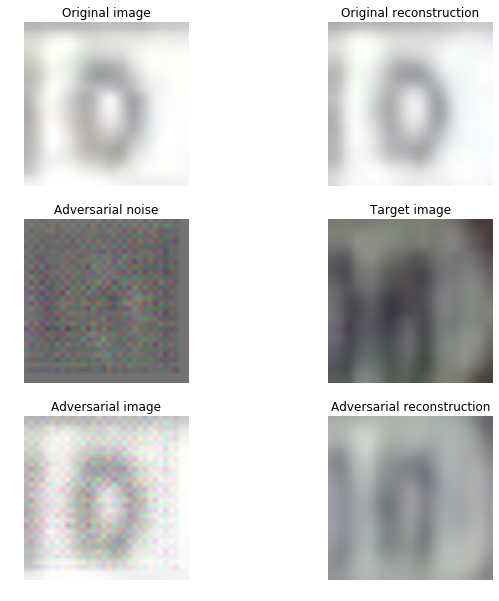

Iter 9 Time 489.132540941 sec
14190 9858 954.757


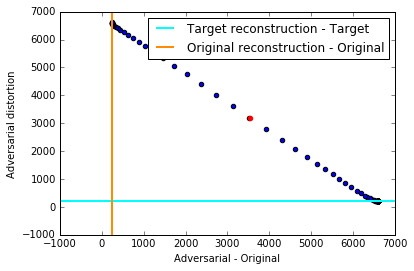

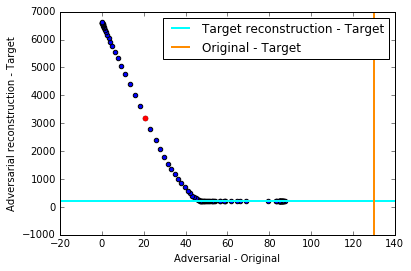

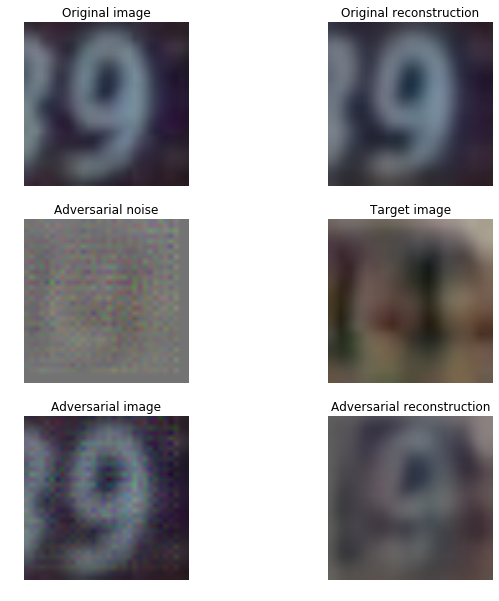

Iter 10 Time 289.128499985 sec
384 13443 545.301


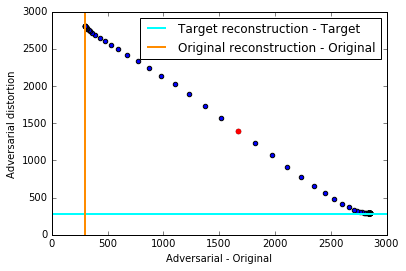

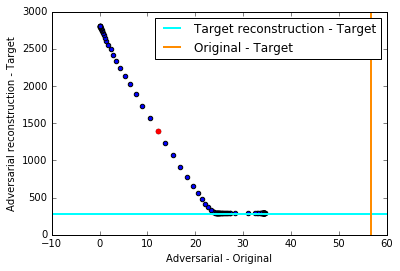

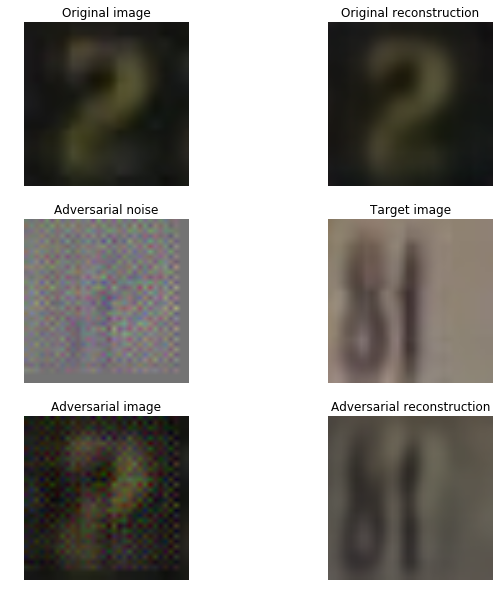

Iter 11 Time 395.240744114 sec
7296 23798 235.37


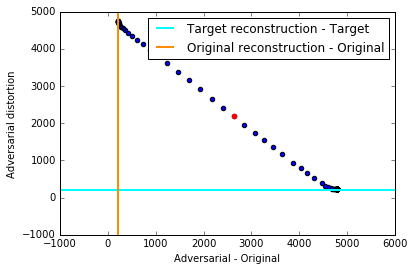

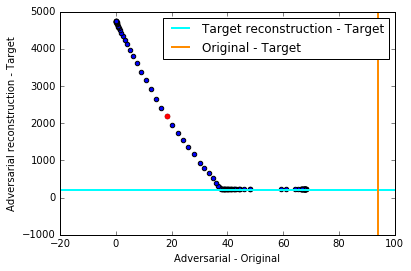

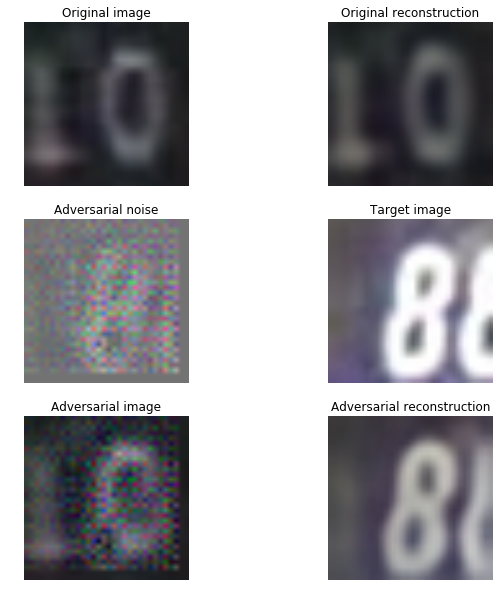

Iter 12 Time 306.100514174 sec
16429 10250 954.757


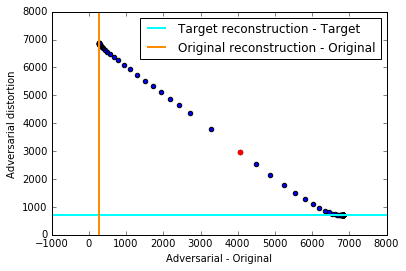

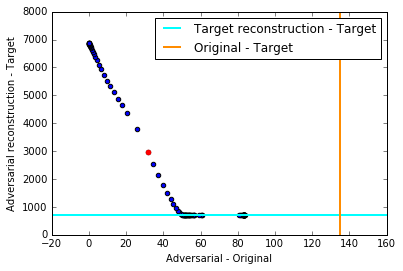

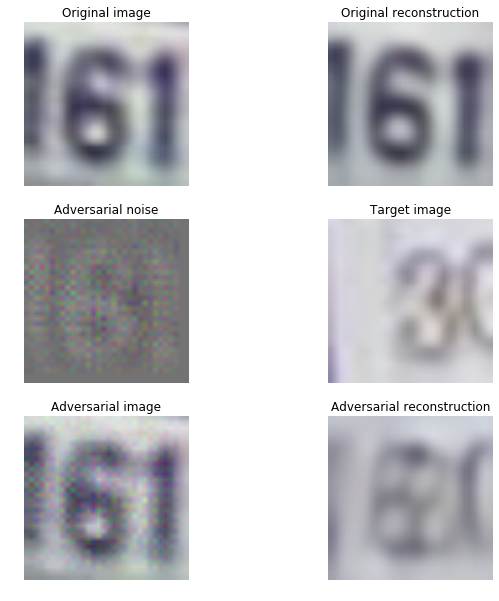

Iter 13 Time 262.653208971 sec
19179 9417 954.757


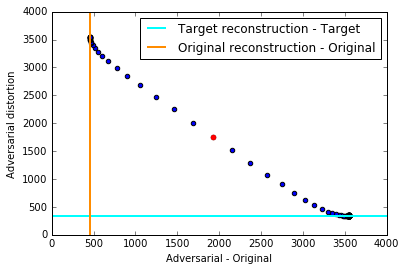

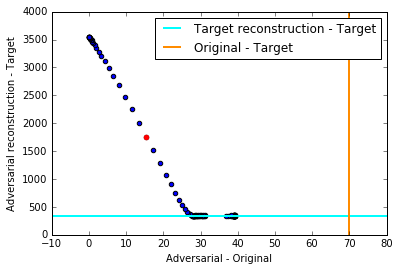

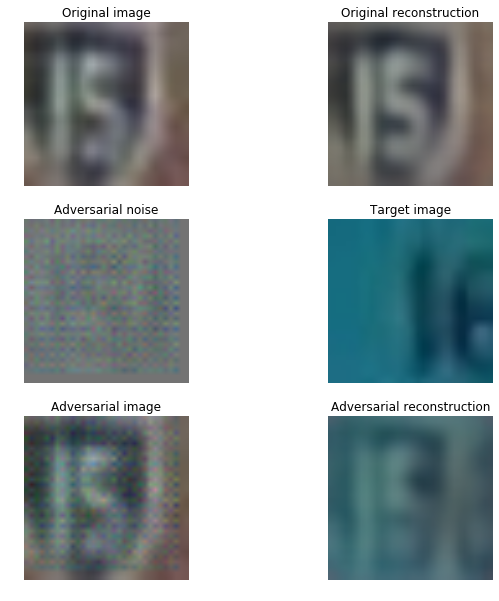

Iter 14 Time 277.625458956 sec
3142 22046 311.444


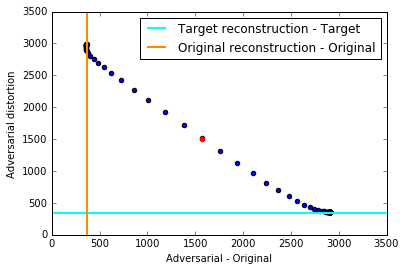

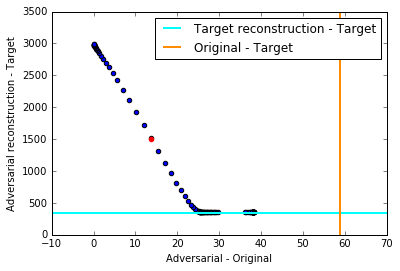

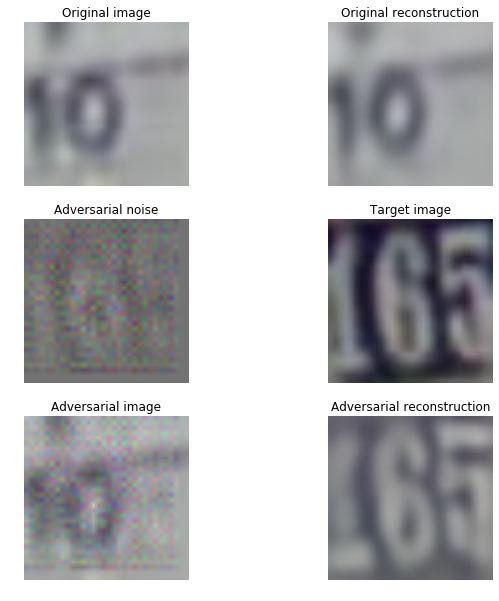

Iter 15 Time 325.625478029 sec
9023 11612 545.301


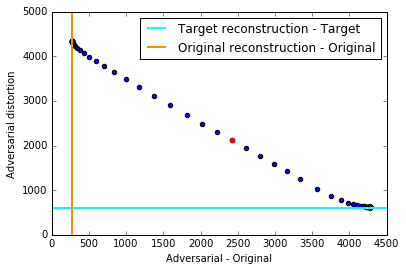

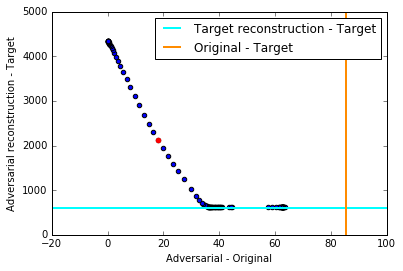

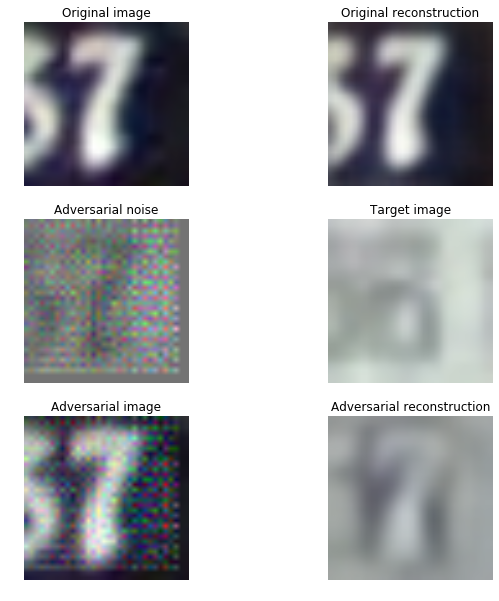

Iter 16 Time 454.234442949 sec
8799 8326 954.757


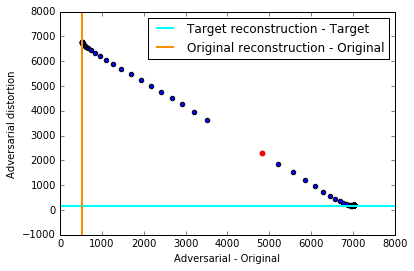

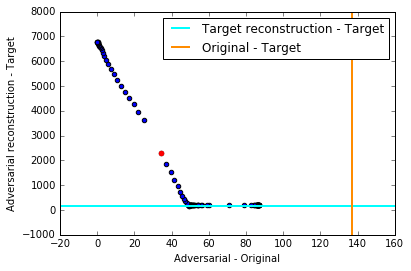

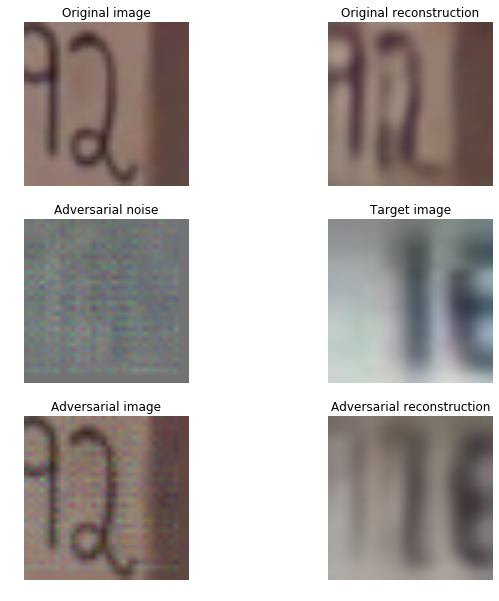

Iter 17 Time 301.694190025 sec
12879 17338 412.105


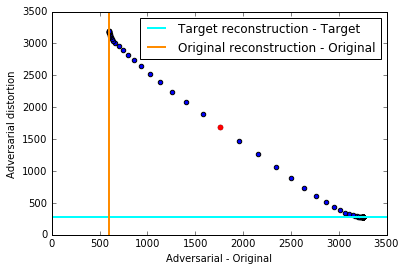

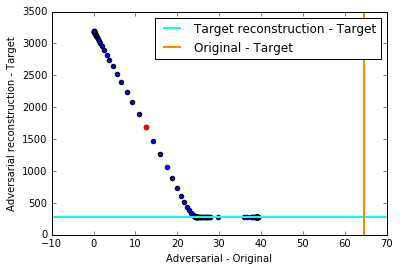

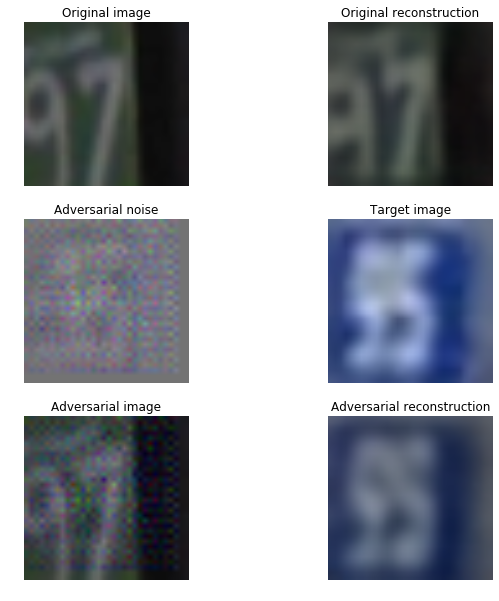

Iter 18 Time 360.326702118 sec
507 15048 1263.34


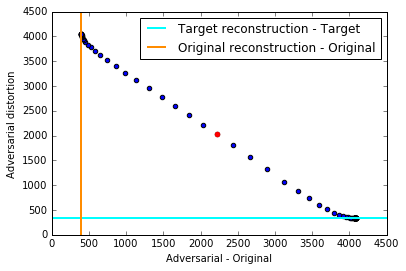

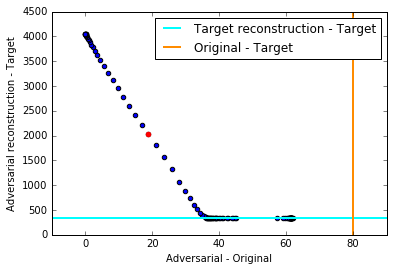

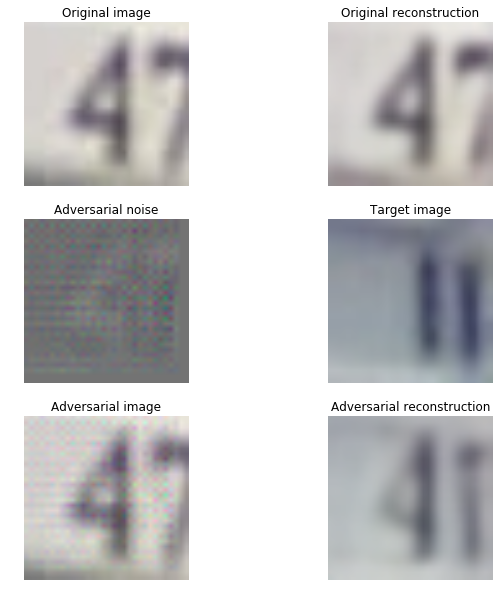

Iter 19 Time 264.674949169 sec
17850 4055 954.757


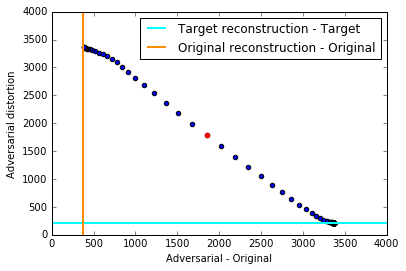

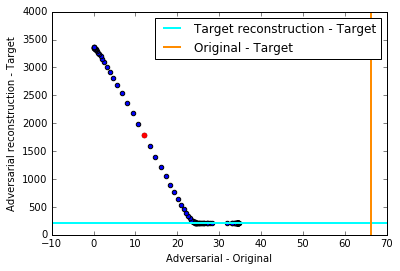

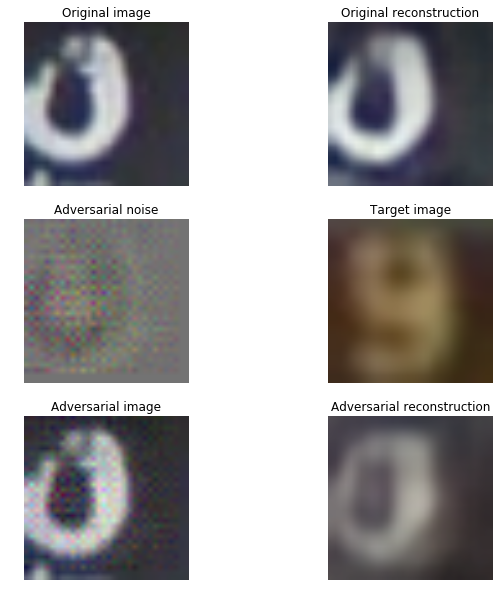

Iter 20 Time 390.651904821 sec
23915 18665 1263.34


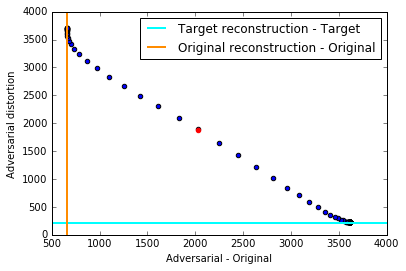

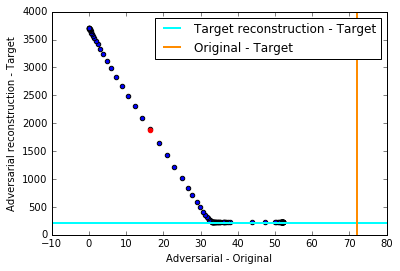

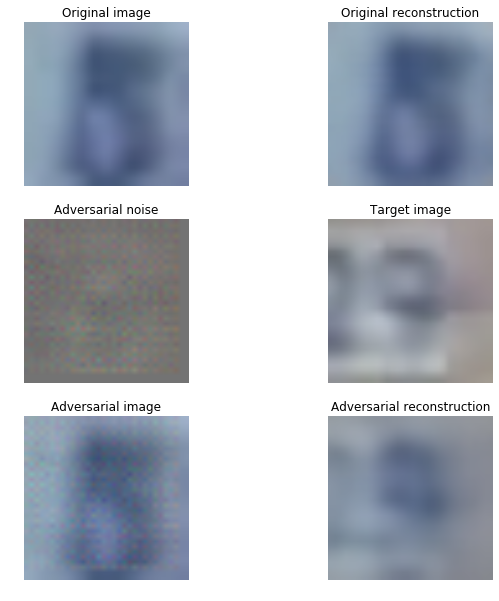

Iter 21 Time 213.084400892 sec
25103 16766 545.301


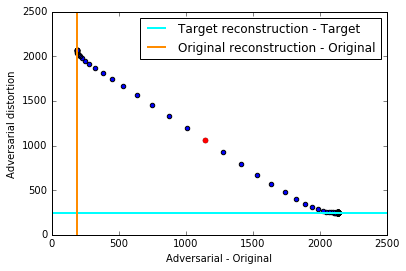

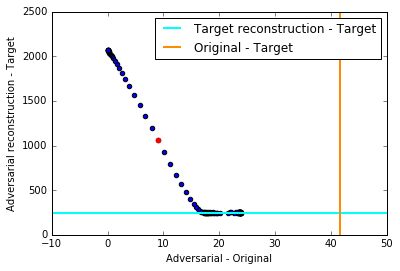

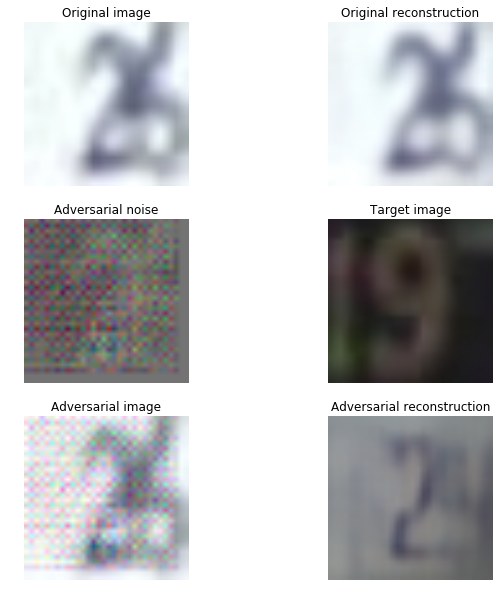

Iter 22 Time 477.587540865 sec
22712 22495 545.301


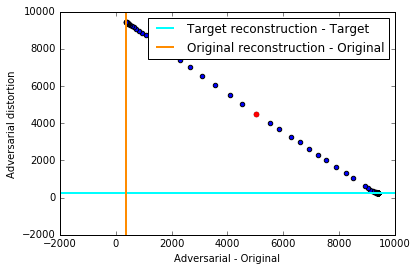

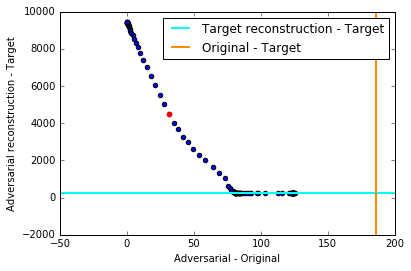

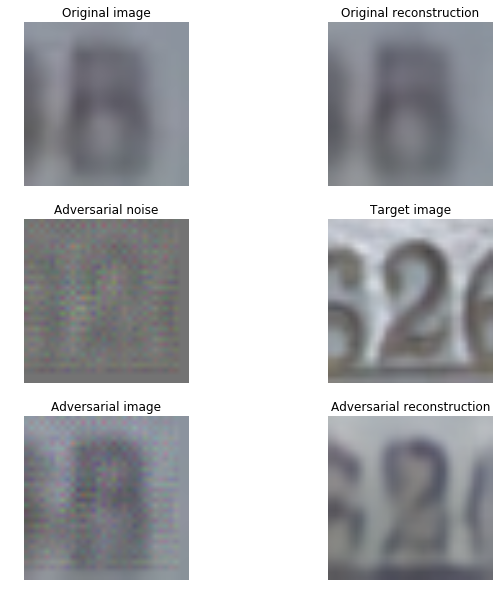

Iter 23 Time 190.867784977 sec
19978 10566 412.105


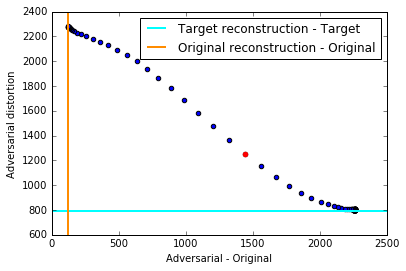

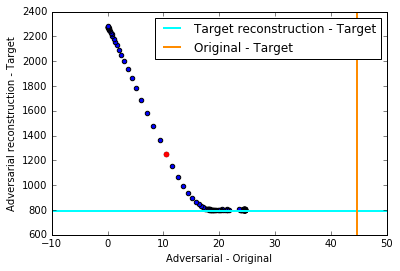

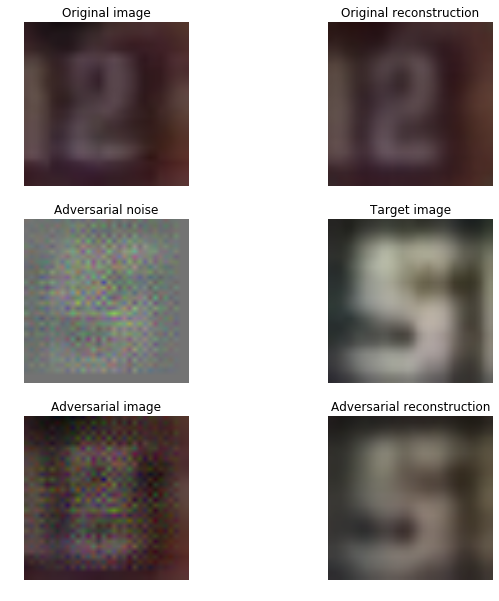

Iter 24 Time 384.715055943 sec


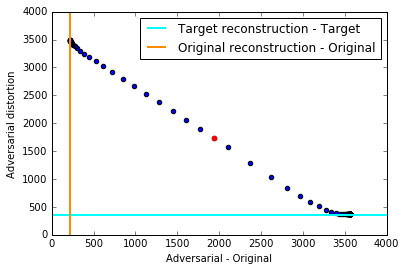

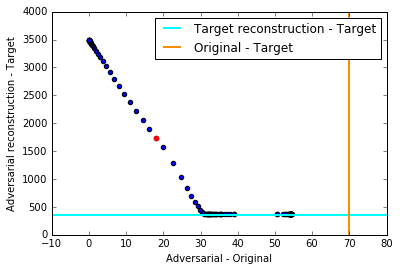

In [20]:
n = 25

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print "Iter", i, "Time", time.time() - start_time, "sec"
    df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv")
    

20525 22198 100


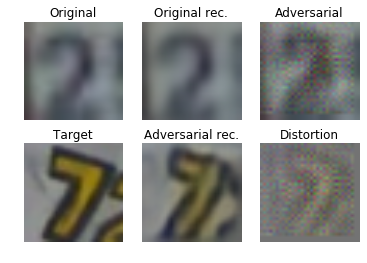

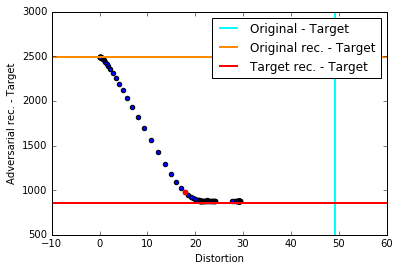

In [25]:
df = orig_adv_dist(20525, 22198, plot = True, bestC = 100)